# Tweet Sentiment Analysis Project

by Garrett Williams, Dave McKinley and Ely Lin of Sphinx Consulting

## Overview

**Business Problem:**

In a world where technology startups are plentiful, consumer sentiment towards a brand can give us a lot of insights into their purchasing decisions, hence the financial performance of the company that makes them. Technology investment company WhiteOre have acquired our services to build them a predictive model that monitors recent tweets on technology products to help them make informed investment decisions. WhiteOre wants a generalizable model to gauge sentiment across different brands, to act as a filtering system to help decide which brands to investigate further for possible investment. WhiteOre only cares about whether people have positive emotions towards the brand because people buy things they like. 


**Target Audience:**

The hedge fund and private equity department of WhiteOre

**Context:**

False positive in this case would mean our model predicts that a consumer has positive emotions towards a brand but they actually don't, leading to overvaluing of a potential investment opportunity and wasting human capital.

False negative in this case would mean our model predicts that a consumer doesn't have positive emotions towards a brand but they actually do, leading to missing a potential investment opportunity.

**Evaluation:**

We don't want to overvalue or undervalue a company, however, the cost of missing the opportunity of getting in early on a good brand that's generating buzz is bigger than spending human resources to evaluate a company and finding out it's not worth investing in. Therefore, we care about maximizing accuracy as well as recall.

**Data Understanding:**

The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither. The tweets included are sent out during the South by South West conference in 2013, mostly about Google and Apple products.

Data source: https://data.world/crowdflower/brands-and-product-emotions

**Modeling**

We used nltk's tweet tokenizer to tokenize the tweets and tfidf vectorizer to vectorize them. 

Modeling techniques include logistic regression, decision trees, random forest, naive bayes, catboost and neural network. 

**Evaluation**

We are able to achieve above 70% accuracy on both training data and testing data on both our naive bayes and neural netword models without overfitting. However, naive bayes requires significantly less computational power so we decide to use naive bayes as our final model. 

## Business Understanding

## Data Understanding

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
# from tensorflow import keras
# from tensorflow.keras import regularizers, layers
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
# from keras.layers import Flatten
# from keras.layers.embeddings import Embedding
# from keras.preprocessing.text import Tokenizer

In [2]:
#load the dataset
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
#rename columns for readability
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head() #Sanity Check

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#looking at data, duplicates and null values
print(df.info())
print(("-"*20))
print(df.duplicated().sum())
print(("-"*20))
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
22
--------------------
Tweet           1
Product      5802
Sentiment       0
dtype: int64


In [5]:
#Simplify sentiment labels for visualizations
dict_sent = {'No emotion toward brand or product':"No emotion", 
             'Positive emotion':'Positive emotion',
             'Negative emotion':'Negative emotion',
             "I can't tell": "I can't tell"}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [6]:
#sentiment breakdown
df['Sentiment'].value_counts() 

No emotion          5389
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: Sentiment, dtype: int64

In [7]:
#number of tweets per product
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [8]:
#drop any NaN in the Tweet column
df['Tweet'].dropna(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [9]:
#drop duplicates
df.drop_duplicates(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [10]:
#drops Tweets with nonsensical characters
df.drop([6, 9092], inplace=True)

In [11]:
#reset the index after cleaning
df.reset_index(inplace=True)
df.drop(columns="index", inplace = True)

In [12]:
#looks at cleaned dataframe
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",NaN,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9067,"Google's Zeiger, a physician never reported po...",NaN,No emotion


In [13]:
#looks at remaining NaN's
print(df.isna().sum())

Tweet           0
Product      5787
Sentiment       0
dtype: int64


In [14]:
#Fills NaN's with "Undefined" to help with data visualizations
df['Product'].fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


In [15]:
#Fills NaN's with "Undefined" to help with data visualizations
df.Product.fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


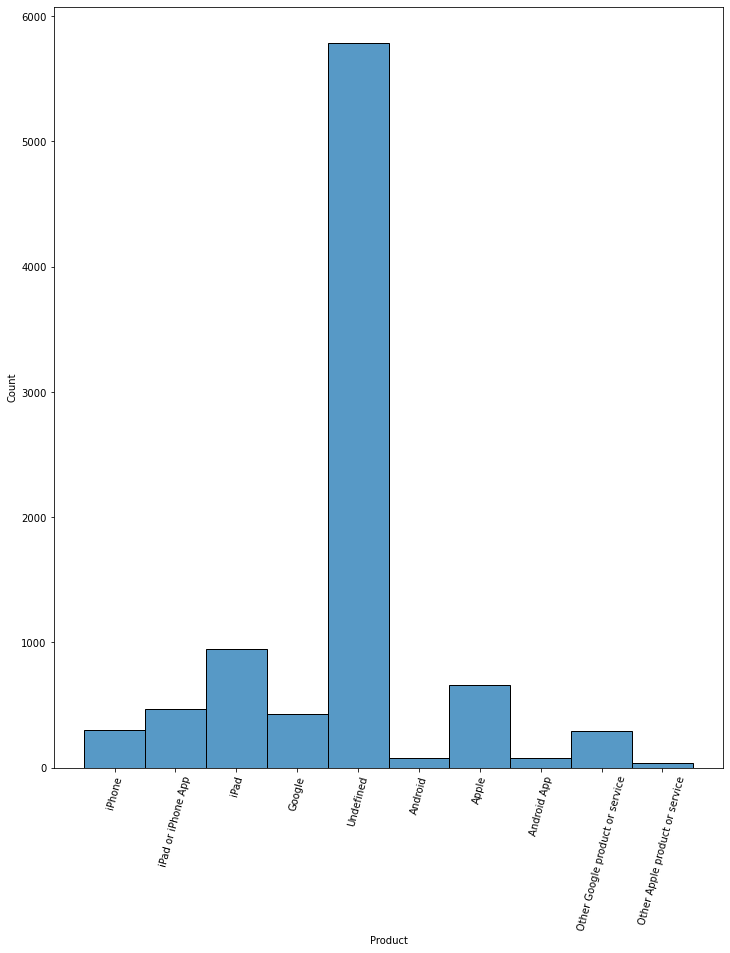

In [16]:
fig, ax = plt.subplots(figsize=(12,14))
sns.histplot(df["Product"] )
plt.xticks(rotation = 75)
plt.show()

In [17]:
#we are going to set the Product type as a string for our function below.
df["Product"].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9064             Undefined
9065                  iPad
9066             Undefined
9067             Undefined
9068             Undefined
Name: Product, Length: 9069, dtype: object

In [18]:
def find_brand(Product, Tweet):
    """
    This function is designed to take build a brand column based on the Product description. 
    After, the function will look at the Tweets and determine a brand for rows with no brand determined.
    
    Product -  a column teh function is working on
    Tweet - a column teh function is working on
    """
    brand = 'Undetermined' #Labeling brand as Undetermined
    if ((Product.lower().__contains__('google')) or (Product.lower().__contains__('android'))): #Labeling Google
        brand = 'Google' #Unless tweet contains google or android
    elif ((Product.lower().__contains__('apple')) or (Product.lower().__contains__('ip'))): #Labeling Apple
        brand = 'Apple' #Unless tweet contains apple or ip
    
    if (brand == 'Undetermined'): 
        lower_tweet = Tweet.lower() #Making tweet lowercase
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [19]:
#Sanity Check
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [20]:
def countplot(df, col, hue=None, rotation=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
    ax.set_title(f"Number of Tweets per {col}", fontsize = 30)
    plt.show()

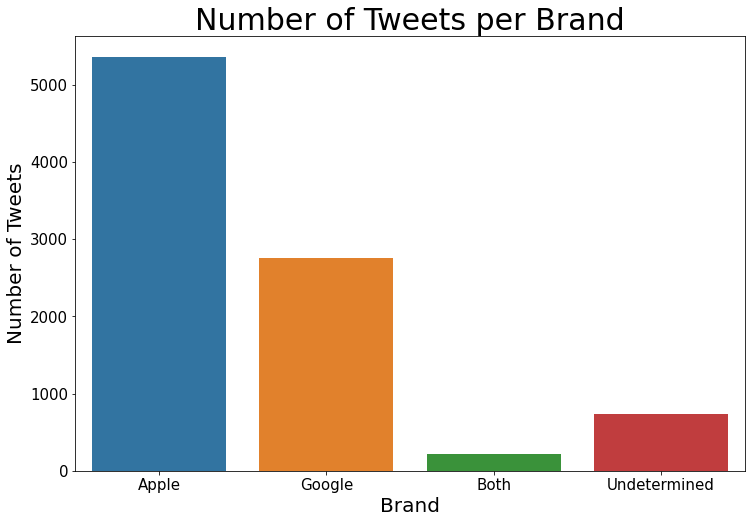

In [21]:
#countplot for Brand
countplot(df, "Brand")

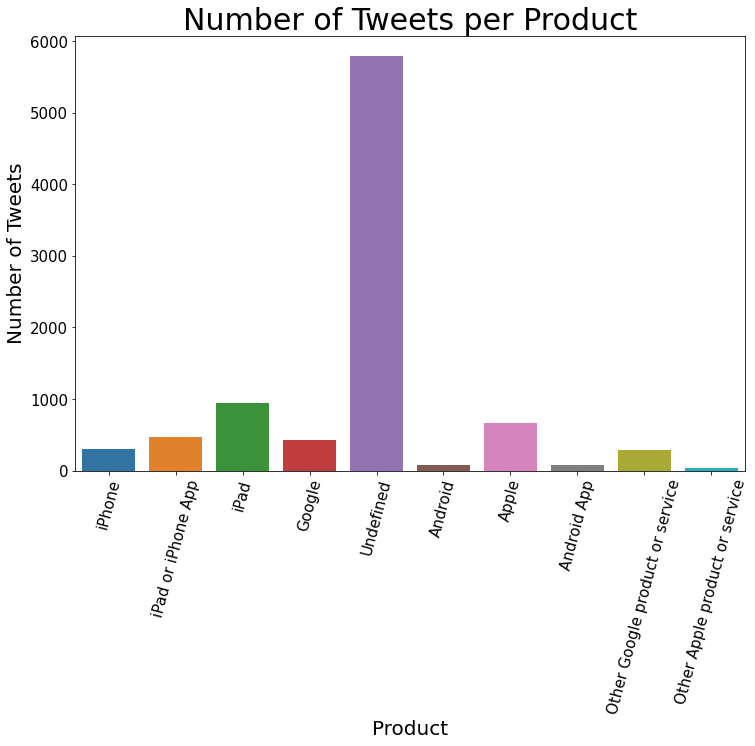

In [22]:
#countplot for Product
countplot(df, "Product", hue=None, rotation=75)

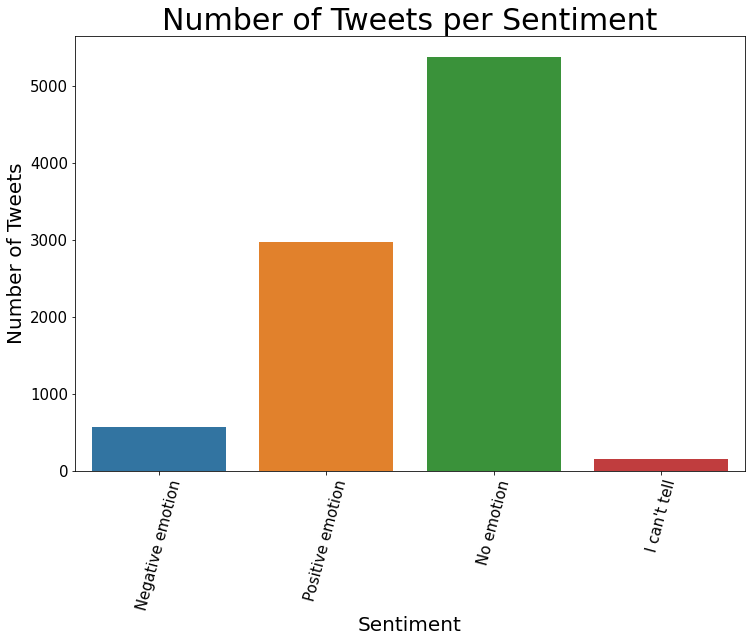

In [23]:
# Count plot for sentiment
countplot(df, "Sentiment", rotation = 75)

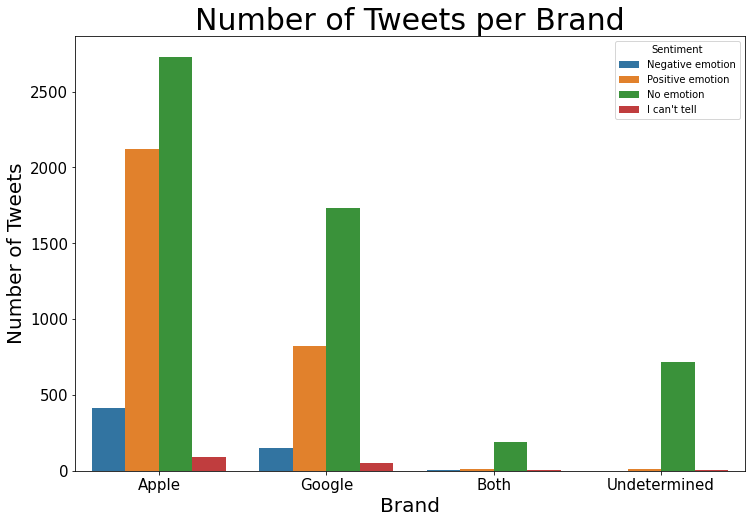

In [24]:
#count plot for Sentiment across brands
countplot(df, "Brand", hue = "Sentiment")

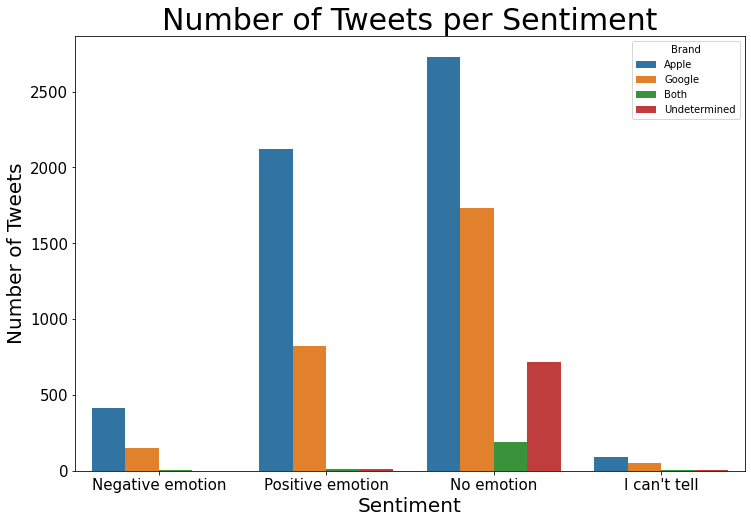

In [25]:
#countplot for brand make of sentiment
countplot(df, "Sentiment", hue="Brand")

In [26]:
#looking at the number of tweets per brand per sentiment
grouped = df.groupby(["Brand", "Sentiment"]).count()
grouped

Tweet  Product
Brand        Sentiment                       
Apple        I can't tell         93       93
             Negative emotion    415      415
             No emotion         2730     2730
             Positive emotion   2123     2123
Both         I can't tell          7        7
             Negative emotion      3        3
             No emotion          192      192
             Positive emotion     11       11
Google       I can't tell         50       50
             Negative emotion    150      150
             No emotion         1733     1733
             Positive emotion    823      823
Undetermined I can't tell          6        6
             Negative emotion      1        1
             No emotion          719      719
             Positive emotion     13       13

In [27]:
#looking at sentitmental breakdown of brands
display(df.groupby(['Sentiment'])['Brand'].value_counts(normalize = True))
print("-"*60)
display(df.groupby(['Brand'])['Sentiment'].value_counts(normalize = True))

Sentiment         Brand       
I can't tell      Apple           0.596154
                  Google          0.320513
                  Both            0.044872
                  Undetermined    0.038462
Negative emotion  Apple           0.729350
                  Google          0.263620
                  Both            0.005272
                  Undetermined    0.001757
No emotion        Apple           0.508001
                  Google          0.322479
                  Undetermined    0.133792
                  Both            0.035728
Positive emotion  Apple           0.714815
                  Google          0.277104
                  Undetermined    0.004377
                  Both            0.003704
Name: Brand, dtype: float64

------------------------------------------------------------


Brand         Sentiment       
Apple         No emotion          0.509233
              Positive emotion    0.396008
              Negative emotion    0.077411
              I can't tell        0.017348
Both          No emotion          0.901408
              Positive emotion    0.051643
              I can't tell        0.032864
              Negative emotion    0.014085
Google        No emotion          0.628810
              Positive emotion    0.298621
              Negative emotion    0.054427
              I can't tell        0.018142
Undetermined  No emotion          0.972936
              Positive emotion    0.017591
              I can't tell        0.008119
              Negative emotion    0.001353
Name: Sentiment, dtype: float64

In [28]:
#Number of Tweets per product
df["Product"].value_counts()

Undefined                          5787
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product, dtype: int64

In [29]:
#Number of Tweets per Sentiment
df["Sentiment"].value_counts()

No emotion          5374
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: Sentiment, dtype: int64

In [30]:
#Number of Tweet per Brand
df["Brand"].value_counts()

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [31]:
#Final DataFrame before Preprocessing
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


## Data Preprocessing

In [32]:
#Turn our Target into a Binary number
dict_sent = {'No emotion':0, 
             'Positive emotion':1,
             'Negative emotion':0,
             "I can't tell": 0}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [33]:
#Create the X DataFrame with only the tweets
X = df[['Tweet']]
#Create the y Series with only the sentiments, 1 for Positive, 0 for not Positive
y = df['Sentiment']
#First train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#Second train test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

Doing the train-test split before the Data Preprocessing prevents data leakage.

In [34]:
#Baseline Understanding
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

In [35]:
#Check first few rows in X_train
X_train.head()

,Tweet
2320,@mention Can we make you an iPhone case with T...
5622,RT @mention Come party down with @mention &amp...
1748,#winning #winning - just gave away 5 red mophi...
5789,RT @mention google &amp; facebook have an offi...
3334,Rumor of Google launching their new social net...


In [36]:
#Check how many rows X_train has
X_train.shape

(6121, 1)

In [37]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
stopwords_list.append("sxsw") #remove sxsw because it's the hashtag for the event
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [38]:
def clean_tweets(text):
    #Use TweetTokenizer object to remove the handles from the Tweet
    #TweetTokenizer also puts each punctuation as it's own token
    no_handle = tweet_tknzr.tokenize(text)
    #Join the list of non-handle tokens back together
    tweet = " ".join(no_handle) 
    #remove http websites, hashtag sign, any words in curly brackets,
        #any words with ampersand in front, www dot com websites, links,
        #videos, and non-english characters
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    #Turn all the tokens lowercase
    lower = clean.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return cleaned_string

In [39]:
#Sanity Check
clean_tweets(X_train['Tweet'].iloc[0])

'make iphone case ttye time want show support'

In [40]:
#Apply our clean_tweets function to X_train, X_val, X_test
X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))
X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))

<ipython-input-40-4c1b95869ad2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
<ipython-input-40-4c1b95869ad2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))
<ipython-input-40-4c1b95869ad2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [41]:
#Sanity Check
X_train

,Tweet
2320,make iphone case ttye time want show support
5622,come party google tonight link band food art i...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...
...,...
5692,even security guard austin enjoy ipad time link
8582,attending want explore austin check austin lin...
7815,apple popup store link gonnagetanipad2
7483,putting pop apple store smart talk understandi...


## Modeling

### 1st Iteration: Simple Naive Bayes

In [42]:
#Create a pipeline to use an Untuned TfidfVectorizer() and MultinomialNB()
pipe_nb = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Cross validate
cv_nb = cross_validate(pipe_nb, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb

{'fit_time': array([0.04424882, 0.03945994, 0.03981495, 0.03991103, 0.04075289]),
 'score_time': array([0.01993489, 0.01797009, 0.01856303, 0.018399  , 0.01866031]),
 'test_accuracy': array([0.70612245, 0.70506536, 0.69934641, 0.69444444, 0.70915033]),
 'train_accuracy': array([0.78696895, 0.7945681 , 0.78742087, 0.79252604, 0.79048397]),
 'test_recall': array([0.15365239, 0.14646465, 0.12626263, 0.13636364, 0.16161616]),
 'train_recall': array([0.35669192, 0.38170347, 0.35772871, 0.37223975, 0.36719243]),
 'test_roc_auc': array([0.73155094, 0.6767448 , 0.69595411, 0.70236178, 0.70092379]),
 'train_roc_auc': array([0.88950838, 0.89780161, 0.89179296, 0.89564979, 0.89119786])}

In [43]:
#Get mean accuracy for validation set
cv_nb['test_accuracy'].mean()

0.7028257969854609

### 2nd Iteration: Naive Bayes with a tuned TfidfVectorizer

In [44]:
#Create a pipeline to use an Tuned TfidfVectorizer() and MultinomialNB()
pipe_nb_tuned = Pipeline(steps=[
    ('tfidf_vectorizer_tuned', TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)),
    ('nb_tuned', MultinomialNB())
])
#Cross validate
cv_nb_tuned = cross_validate(pipe_nb_tuned, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb_tuned

{'fit_time': array([0.04148579, 0.03872299, 0.0393002 , 0.03916574, 0.03900003]),
 'score_time': array([0.01795816, 0.01834488, 0.01924992, 0.01789021, 0.01780295]),
 'test_accuracy': array([0.71265306, 0.7001634 , 0.70588235, 0.68954248, 0.70343137]),
 'train_accuracy': array([0.71486928, 0.71880743, 0.71554013, 0.7177864 , 0.71860323]),
 'test_recall': array([0.19647355, 0.18181818, 0.16414141, 0.17676768, 0.16666667]),
 'train_recall': array([0.19318182, 0.20694006, 0.18927445, 0.21514196, 0.20315457]),
 'test_roc_auc': array([0.69983816, 0.65763309, 0.68208352, 0.66534762, 0.6631487 ]),
 'train_roc_auc': array([0.72634787, 0.73428142, 0.72852908, 0.73547677, 0.73252431])}

In [45]:
#Get mean accuracy for validation set
cv_nb_tuned['test_accuracy'].mean()

0.7023345338135255

### 3rd Iteration: Logistic Regression with PCA

In [46]:
#Create a tuned tfidf vectorizer that will be scaled for PCA
tfidf_vectorizer_tuned = TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)

#Fit vectorizer on X_train
tfidf_vectorizer_tuned.fit(X_train['Tweet'])

#Transform X_train and X_val
X_train_tfidf_vec = tfidf_vectorizer_tuned.transform(X_train['Tweet'])
X_val_tfidf_vec = tfidf_vectorizer_tuned.transform(X_val['Tweet'])

#Turn X_train and X_val into DataFrame
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray())

In [47]:
#Create a StandardScaler Object
scaler = StandardScaler()

#Fit scaler to tuned vectorized X_train and transform both X_train and X_val
X_train_scaled = scaler.fit_transform(X_train_tfidf_vec_df)
X_val_scaled = scaler.transform(X_val_tfidf_vec_df)

In [48]:
#Create a PCA object
pca = PCA(n_components = .99, random_state=42)

In [49]:
#Create a Pipeline object for PCA and Logistic Regression
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=42, max_iter=1000))])
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [50]:
#Check results
print("PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes")
print(pipe_lr.score(X_train_scaled, y_train))
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.99, tuned tfidf vectorizer, and naive bayes
0.7250449272994609
0.7099461048505634


### 4th Iteration: CatBoost

In [51]:
#Create a pipeline with CatBoost
pipe_cbc = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)),
    ('cbc', CatBoostClassifier())
])
#Cross Validate
cv_cbc = cross_validate(pipe_cbc, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
cv_cbc

Learning rate set to 0.0203
0:	learn: 0.6902637	total: 65.7ms	remaining: 1m 5s
1:	learn: 0.6870831	total: 70.3ms	remaining: 35.1s
2:	learn: 0.6842005	total: 75.1ms	remaining: 25s
3:	learn: 0.6813913	total: 79.8ms	remaining: 19.9s
4:	learn: 0.6786829	total: 84.5ms	remaining: 16.8s
5:	learn: 0.6760130	total: 89ms	remaining: 14.8s
6:	learn: 0.6735197	total: 94.3ms	remaining: 13.4s
7:	learn: 0.6709083	total: 103ms	remaining: 12.8s
8:	learn: 0.6686067	total: 108ms	remaining: 11.9s
9:	learn: 0.6663636	total: 114ms	remaining: 11.3s
10:	learn: 0.6638154	total: 119ms	remaining: 10.7s
11:	learn: 0.6617643	total: 129ms	remaining: 10.6s
12:	learn: 0.6590251	total: 135ms	remaining: 10.2s
13:	learn: 0.6571200	total: 140ms	remaining: 9.84s
14:	learn: 0.6551573	total: 146ms	remaining: 9.56s
15:	learn: 0.6535155	total: 150ms	remaining: 9.24s
16:	learn: 0.6512920	total: 155ms	remaining: 8.98s
17:	learn: 0.6493126	total: 164ms	remaining: 8.97s
18:	learn: 0.6476004	total: 169ms	remaining: 8.71s
19:	learn:

174:	learn: 0.5723879	total: 988ms	remaining: 4.66s
175:	learn: 0.5721704	total: 993ms	remaining: 4.65s
176:	learn: 0.5719756	total: 998ms	remaining: 4.64s
177:	learn: 0.5717903	total: 1s	remaining: 4.63s
178:	learn: 0.5715983	total: 1.01s	remaining: 4.63s
179:	learn: 0.5713731	total: 1.02s	remaining: 4.63s
180:	learn: 0.5711574	total: 1.02s	remaining: 4.62s
181:	learn: 0.5710087	total: 1.02s	remaining: 4.61s
182:	learn: 0.5707841	total: 1.03s	remaining: 4.6s
183:	learn: 0.5705543	total: 1.04s	remaining: 4.59s
184:	learn: 0.5704158	total: 1.04s	remaining: 4.58s
185:	learn: 0.5702449	total: 1.04s	remaining: 4.58s
186:	learn: 0.5701207	total: 1.05s	remaining: 4.56s
187:	learn: 0.5699600	total: 1.05s	remaining: 4.55s
188:	learn: 0.5697654	total: 1.06s	remaining: 4.54s
189:	learn: 0.5696660	total: 1.06s	remaining: 4.53s
190:	learn: 0.5694345	total: 1.07s	remaining: 4.52s
191:	learn: 0.5692834	total: 1.07s	remaining: 4.51s
192:	learn: 0.5691776	total: 1.08s	remaining: 4.51s
193:	learn: 0.56

338:	learn: 0.5468245	total: 2s	remaining: 3.9s
339:	learn: 0.5467129	total: 2.01s	remaining: 3.89s
340:	learn: 0.5465795	total: 2.01s	remaining: 3.89s
341:	learn: 0.5464888	total: 2.02s	remaining: 3.88s
342:	learn: 0.5463646	total: 2.03s	remaining: 3.88s
343:	learn: 0.5462301	total: 2.03s	remaining: 3.87s
344:	learn: 0.5460958	total: 2.04s	remaining: 3.87s
345:	learn: 0.5459709	total: 2.04s	remaining: 3.86s
346:	learn: 0.5458220	total: 2.04s	remaining: 3.85s
347:	learn: 0.5456947	total: 2.05s	remaining: 3.84s
348:	learn: 0.5455924	total: 2.06s	remaining: 3.84s
349:	learn: 0.5453844	total: 2.06s	remaining: 3.83s
350:	learn: 0.5452581	total: 2.07s	remaining: 3.84s
351:	learn: 0.5451207	total: 2.08s	remaining: 3.83s
352:	learn: 0.5449943	total: 2.09s	remaining: 3.83s
353:	learn: 0.5448724	total: 2.09s	remaining: 3.82s
354:	learn: 0.5447011	total: 2.1s	remaining: 3.81s
355:	learn: 0.5444993	total: 2.1s	remaining: 3.8s
356:	learn: 0.5443341	total: 2.11s	remaining: 3.8s
357:	learn: 0.544075

497:	learn: 0.5250462	total: 2.9s	remaining: 2.92s
498:	learn: 0.5249448	total: 2.91s	remaining: 2.92s
499:	learn: 0.5247968	total: 2.91s	remaining: 2.91s
500:	learn: 0.5247061	total: 2.92s	remaining: 2.91s
501:	learn: 0.5246015	total: 2.92s	remaining: 2.9s
502:	learn: 0.5244449	total: 2.93s	remaining: 2.89s
503:	learn: 0.5242265	total: 2.94s	remaining: 2.89s
504:	learn: 0.5240548	total: 2.94s	remaining: 2.89s
505:	learn: 0.5238925	total: 2.95s	remaining: 2.88s
506:	learn: 0.5237347	total: 2.96s	remaining: 2.87s
507:	learn: 0.5235430	total: 2.96s	remaining: 2.87s
508:	learn: 0.5233518	total: 2.97s	remaining: 2.87s
509:	learn: 0.5231947	total: 2.98s	remaining: 2.86s
510:	learn: 0.5231070	total: 2.98s	remaining: 2.85s
511:	learn: 0.5229713	total: 2.99s	remaining: 2.85s
512:	learn: 0.5229108	total: 3s	remaining: 2.85s
513:	learn: 0.5227648	total: 3s	remaining: 2.84s
514:	learn: 0.5225731	total: 3.01s	remaining: 2.83s
515:	learn: 0.5223871	total: 3.01s	remaining: 2.83s
516:	learn: 0.522294

657:	learn: 0.5024537	total: 3.9s	remaining: 2.03s
658:	learn: 0.5022774	total: 3.91s	remaining: 2.02s
659:	learn: 0.5021622	total: 3.91s	remaining: 2.02s
660:	learn: 0.5021109	total: 3.92s	remaining: 2.01s
661:	learn: 0.5019252	total: 3.92s	remaining: 2s
662:	learn: 0.5017526	total: 3.93s	remaining: 2s
663:	learn: 0.5016138	total: 3.94s	remaining: 1.99s
664:	learn: 0.5015674	total: 3.94s	remaining: 1.99s
665:	learn: 0.5015099	total: 3.95s	remaining: 1.98s
666:	learn: 0.5013902	total: 3.96s	remaining: 1.97s
667:	learn: 0.5012318	total: 3.96s	remaining: 1.97s
668:	learn: 0.5009922	total: 3.96s	remaining: 1.96s
669:	learn: 0.5008389	total: 3.97s	remaining: 1.96s
670:	learn: 0.5006519	total: 3.97s	remaining: 1.95s
671:	learn: 0.5004875	total: 3.98s	remaining: 1.94s
672:	learn: 0.5004336	total: 3.99s	remaining: 1.94s
673:	learn: 0.5003529	total: 3.99s	remaining: 1.93s
674:	learn: 0.5002642	total: 4s	remaining: 1.92s
675:	learn: 0.5000678	total: 4s	remaining: 1.92s
676:	learn: 0.4999447	tot

830:	learn: 0.4800841	total: 4.9s	remaining: 997ms
831:	learn: 0.4799670	total: 4.91s	remaining: 991ms
832:	learn: 0.4798630	total: 4.91s	remaining: 984ms
833:	learn: 0.4797413	total: 4.92s	remaining: 979ms
834:	learn: 0.4797048	total: 4.92s	remaining: 973ms
835:	learn: 0.4796698	total: 4.93s	remaining: 967ms
836:	learn: 0.4795456	total: 4.93s	remaining: 961ms
837:	learn: 0.4795120	total: 4.94s	remaining: 955ms
838:	learn: 0.4794236	total: 4.94s	remaining: 949ms
839:	learn: 0.4792673	total: 4.95s	remaining: 943ms
840:	learn: 0.4791289	total: 4.95s	remaining: 937ms
841:	learn: 0.4790240	total: 4.96s	remaining: 931ms
842:	learn: 0.4788553	total: 4.97s	remaining: 926ms
843:	learn: 0.4786320	total: 4.98s	remaining: 921ms
844:	learn: 0.4785613	total: 4.99s	remaining: 915ms
845:	learn: 0.4784357	total: 4.99s	remaining: 908ms
846:	learn: 0.4782936	total: 5s	remaining: 903ms
847:	learn: 0.4781539	total: 5s	remaining: 897ms
848:	learn: 0.4781310	total: 5.01s	remaining: 891ms
849:	learn: 0.47805

Learning rate set to 0.020302
0:	learn: 0.6902122	total: 6.62ms	remaining: 6.61s
1:	learn: 0.6870722	total: 11ms	remaining: 5.51s
2:	learn: 0.6841294	total: 15.5ms	remaining: 5.16s
3:	learn: 0.6813885	total: 22.3ms	remaining: 5.56s
4:	learn: 0.6783965	total: 26.5ms	remaining: 5.27s
5:	learn: 0.6759743	total: 31ms	remaining: 5.14s
6:	learn: 0.6735212	total: 35.5ms	remaining: 5.03s
7:	learn: 0.6713495	total: 41.4ms	remaining: 5.14s
8:	learn: 0.6691912	total: 45.6ms	remaining: 5.02s
9:	learn: 0.6667027	total: 50ms	remaining: 4.95s
10:	learn: 0.6641759	total: 54.2ms	remaining: 4.87s
11:	learn: 0.6619841	total: 58.8ms	remaining: 4.84s
12:	learn: 0.6599580	total: 64ms	remaining: 4.86s
13:	learn: 0.6581293	total: 70.6ms	remaining: 4.97s
14:	learn: 0.6562152	total: 74.8ms	remaining: 4.91s
15:	learn: 0.6542474	total: 79.1ms	remaining: 4.86s
16:	learn: 0.6526210	total: 83.3ms	remaining: 4.82s
17:	learn: 0.6509921	total: 88.6ms	remaining: 4.83s
18:	learn: 0.6491525	total: 93ms	remaining: 4.8s
19:

166:	learn: 0.5730985	total: 983ms	remaining: 4.9s
167:	learn: 0.5727889	total: 987ms	remaining: 4.89s
168:	learn: 0.5725591	total: 993ms	remaining: 4.88s
169:	learn: 0.5723273	total: 998ms	remaining: 4.87s
170:	learn: 0.5721406	total: 1s	remaining: 4.87s
171:	learn: 0.5719620	total: 1.01s	remaining: 4.86s
172:	learn: 0.5716804	total: 1.01s	remaining: 4.85s
173:	learn: 0.5714824	total: 1.02s	remaining: 4.84s
174:	learn: 0.5712395	total: 1.03s	remaining: 4.84s
175:	learn: 0.5710310	total: 1.03s	remaining: 4.85s
176:	learn: 0.5709000	total: 1.04s	remaining: 4.84s
177:	learn: 0.5706235	total: 1.05s	remaining: 4.83s
178:	learn: 0.5704480	total: 1.05s	remaining: 4.82s
179:	learn: 0.5701370	total: 1.05s	remaining: 4.8s
180:	learn: 0.5698672	total: 1.06s	remaining: 4.79s
181:	learn: 0.5697241	total: 1.06s	remaining: 4.79s
182:	learn: 0.5695566	total: 1.07s	remaining: 4.78s
183:	learn: 0.5693841	total: 1.07s	remaining: 4.77s
184:	learn: 0.5691453	total: 1.08s	remaining: 4.76s
185:	learn: 0.568

346:	learn: 0.5441537	total: 1.97s	remaining: 3.71s
347:	learn: 0.5440390	total: 1.98s	remaining: 3.71s
348:	learn: 0.5439062	total: 1.99s	remaining: 3.71s
349:	learn: 0.5437699	total: 2s	remaining: 3.71s
350:	learn: 0.5436628	total: 2s	remaining: 3.7s
351:	learn: 0.5434905	total: 2s	remaining: 3.69s
352:	learn: 0.5433788	total: 2.01s	remaining: 3.68s
353:	learn: 0.5432765	total: 2.01s	remaining: 3.68s
354:	learn: 0.5431514	total: 2.02s	remaining: 3.67s
355:	learn: 0.5430184	total: 2.02s	remaining: 3.66s
356:	learn: 0.5429004	total: 2.03s	remaining: 3.66s
357:	learn: 0.5428544	total: 2.04s	remaining: 3.65s
358:	learn: 0.5426919	total: 2.04s	remaining: 3.65s
359:	learn: 0.5425675	total: 2.05s	remaining: 3.64s
360:	learn: 0.5425015	total: 2.06s	remaining: 3.64s
361:	learn: 0.5423872	total: 2.06s	remaining: 3.63s
362:	learn: 0.5422117	total: 2.06s	remaining: 3.62s
363:	learn: 0.5421162	total: 2.07s	remaining: 3.62s
364:	learn: 0.5420247	total: 2.08s	remaining: 3.61s
365:	learn: 0.5419480	

509:	learn: 0.5203911	total: 2.98s	remaining: 2.86s
510:	learn: 0.5202741	total: 2.98s	remaining: 2.85s
511:	learn: 0.5201019	total: 2.99s	remaining: 2.85s
512:	learn: 0.5199296	total: 2.99s	remaining: 2.84s
513:	learn: 0.5197581	total: 3s	remaining: 2.83s
514:	learn: 0.5196202	total: 3s	remaining: 2.83s
515:	learn: 0.5193483	total: 3.01s	remaining: 2.82s
516:	learn: 0.5192135	total: 3.01s	remaining: 2.81s
517:	learn: 0.5190507	total: 3.02s	remaining: 2.81s
518:	learn: 0.5188201	total: 3.02s	remaining: 2.8s
519:	learn: 0.5187341	total: 3.03s	remaining: 2.8s
520:	learn: 0.5186603	total: 3.04s	remaining: 2.79s
521:	learn: 0.5184405	total: 3.04s	remaining: 2.79s
522:	learn: 0.5183438	total: 3.05s	remaining: 2.78s
523:	learn: 0.5182497	total: 3.06s	remaining: 2.77s
524:	learn: 0.5180881	total: 3.06s	remaining: 2.77s
525:	learn: 0.5178186	total: 3.07s	remaining: 2.77s
526:	learn: 0.5177679	total: 3.08s	remaining: 2.76s
527:	learn: 0.5176034	total: 3.08s	remaining: 2.76s
528:	learn: 0.517517

688:	learn: 0.4955463	total: 4.16s	remaining: 1.88s
689:	learn: 0.4954317	total: 4.16s	remaining: 1.87s
690:	learn: 0.4953346	total: 4.17s	remaining: 1.86s
691:	learn: 0.4951577	total: 4.18s	remaining: 1.86s
692:	learn: 0.4949966	total: 4.18s	remaining: 1.85s
693:	learn: 0.4948806	total: 4.18s	remaining: 1.84s
694:	learn: 0.4947837	total: 4.19s	remaining: 1.84s
695:	learn: 0.4946015	total: 4.2s	remaining: 1.83s
696:	learn: 0.4945627	total: 4.21s	remaining: 1.83s
697:	learn: 0.4944312	total: 4.21s	remaining: 1.82s
698:	learn: 0.4943671	total: 4.22s	remaining: 1.82s
699:	learn: 0.4942025	total: 4.22s	remaining: 1.81s
700:	learn: 0.4941048	total: 4.23s	remaining: 1.8s
701:	learn: 0.4939147	total: 4.24s	remaining: 1.8s
702:	learn: 0.4937407	total: 4.24s	remaining: 1.79s
703:	learn: 0.4936653	total: 4.25s	remaining: 1.78s
704:	learn: 0.4936270	total: 4.25s	remaining: 1.78s
705:	learn: 0.4934992	total: 4.27s	remaining: 1.78s
706:	learn: 0.4933737	total: 4.27s	remaining: 1.77s
707:	learn: 0.4

859:	learn: 0.4744003	total: 5.35s	remaining: 871ms
860:	learn: 0.4742450	total: 5.36s	remaining: 865ms
861:	learn: 0.4741326	total: 5.36s	remaining: 859ms
862:	learn: 0.4739725	total: 5.37s	remaining: 852ms
863:	learn: 0.4738705	total: 5.38s	remaining: 847ms
864:	learn: 0.4737389	total: 5.38s	remaining: 841ms
865:	learn: 0.4735664	total: 5.39s	remaining: 834ms
866:	learn: 0.4734507	total: 5.4s	remaining: 828ms
867:	learn: 0.4733019	total: 5.4s	remaining: 821ms
868:	learn: 0.4732732	total: 5.41s	remaining: 815ms
869:	learn: 0.4732453	total: 5.42s	remaining: 809ms
870:	learn: 0.4730941	total: 5.42s	remaining: 803ms
871:	learn: 0.4729522	total: 5.43s	remaining: 796ms
872:	learn: 0.4728441	total: 5.43s	remaining: 790ms
873:	learn: 0.4727398	total: 5.44s	remaining: 784ms
874:	learn: 0.4726752	total: 5.44s	remaining: 778ms
875:	learn: 0.4725333	total: 5.45s	remaining: 771ms
876:	learn: 0.4725016	total: 5.45s	remaining: 765ms
877:	learn: 0.4723404	total: 5.46s	remaining: 759ms
878:	learn: 0.

20:	learn: 0.6465245	total: 220ms	remaining: 10.2s
21:	learn: 0.6448956	total: 231ms	remaining: 10.3s
22:	learn: 0.6434488	total: 243ms	remaining: 10.3s
23:	learn: 0.6420302	total: 251ms	remaining: 10.2s
24:	learn: 0.6407980	total: 259ms	remaining: 10.1s
25:	learn: 0.6394612	total: 270ms	remaining: 10.1s
26:	learn: 0.6382155	total: 277ms	remaining: 9.99s
27:	learn: 0.6366805	total: 285ms	remaining: 9.89s
28:	learn: 0.6353635	total: 292ms	remaining: 9.79s
29:	learn: 0.6339726	total: 300ms	remaining: 9.7s
30:	learn: 0.6327418	total: 307ms	remaining: 9.6s
31:	learn: 0.6316471	total: 315ms	remaining: 9.53s
32:	learn: 0.6306208	total: 323ms	remaining: 9.47s
33:	learn: 0.6296794	total: 331ms	remaining: 9.39s
34:	learn: 0.6285998	total: 344ms	remaining: 9.49s
35:	learn: 0.6274481	total: 352ms	remaining: 9.43s
36:	learn: 0.6264800	total: 360ms	remaining: 9.37s
37:	learn: 0.6256017	total: 370ms	remaining: 9.37s
38:	learn: 0.6245218	total: 377ms	remaining: 9.3s
39:	learn: 0.6235958	total: 385ms	

198:	learn: 0.5687640	total: 1.84s	remaining: 7.42s
199:	learn: 0.5685416	total: 1.85s	remaining: 7.4s
200:	learn: 0.5683776	total: 1.86s	remaining: 7.39s
201:	learn: 0.5681456	total: 1.87s	remaining: 7.37s
202:	learn: 0.5679222	total: 1.87s	remaining: 7.36s
203:	learn: 0.5675804	total: 1.88s	remaining: 7.35s
204:	learn: 0.5673405	total: 1.89s	remaining: 7.33s
205:	learn: 0.5672673	total: 1.9s	remaining: 7.34s
206:	learn: 0.5670812	total: 1.92s	remaining: 7.34s
207:	learn: 0.5668559	total: 1.93s	remaining: 7.33s
208:	learn: 0.5667330	total: 1.94s	remaining: 7.33s
209:	learn: 0.5665609	total: 1.95s	remaining: 7.32s
210:	learn: 0.5662904	total: 1.95s	remaining: 7.3s
211:	learn: 0.5661836	total: 1.96s	remaining: 7.29s
212:	learn: 0.5660125	total: 1.97s	remaining: 7.28s
213:	learn: 0.5658752	total: 1.98s	remaining: 7.27s
214:	learn: 0.5657334	total: 1.99s	remaining: 7.25s
215:	learn: 0.5655978	total: 1.99s	remaining: 7.24s
216:	learn: 0.5654020	total: 2s	remaining: 7.22s
217:	learn: 0.5651

364:	learn: 0.5439580	total: 3.25s	remaining: 5.66s
365:	learn: 0.5437719	total: 3.26s	remaining: 5.65s
366:	learn: 0.5436619	total: 3.27s	remaining: 5.64s
367:	learn: 0.5435020	total: 3.28s	remaining: 5.63s
368:	learn: 0.5433522	total: 3.29s	remaining: 5.62s
369:	learn: 0.5432408	total: 3.29s	remaining: 5.61s
370:	learn: 0.5430642	total: 3.3s	remaining: 5.6s
371:	learn: 0.5429422	total: 3.31s	remaining: 5.59s
372:	learn: 0.5428169	total: 3.32s	remaining: 5.58s
373:	learn: 0.5427155	total: 3.33s	remaining: 5.57s
374:	learn: 0.5425946	total: 3.34s	remaining: 5.56s
375:	learn: 0.5424409	total: 3.34s	remaining: 5.55s
376:	learn: 0.5423129	total: 3.35s	remaining: 5.54s
377:	learn: 0.5421522	total: 3.36s	remaining: 5.53s
378:	learn: 0.5418055	total: 3.37s	remaining: 5.52s
379:	learn: 0.5416318	total: 3.38s	remaining: 5.51s
380:	learn: 0.5415114	total: 3.38s	remaining: 5.5s
381:	learn: 0.5414422	total: 3.4s	remaining: 5.49s
382:	learn: 0.5413513	total: 3.4s	remaining: 5.48s
383:	learn: 0.541

539:	learn: 0.5187510	total: 4.85s	remaining: 4.13s
540:	learn: 0.5186217	total: 4.87s	remaining: 4.13s
541:	learn: 0.5185623	total: 4.88s	remaining: 4.12s
542:	learn: 0.5183954	total: 4.89s	remaining: 4.11s
543:	learn: 0.5183406	total: 4.9s	remaining: 4.11s
544:	learn: 0.5181858	total: 4.91s	remaining: 4.1s
545:	learn: 0.5180245	total: 4.91s	remaining: 4.09s
546:	learn: 0.5178124	total: 4.92s	remaining: 4.08s
547:	learn: 0.5176340	total: 4.95s	remaining: 4.08s
548:	learn: 0.5175536	total: 4.96s	remaining: 4.07s
549:	learn: 0.5172857	total: 4.97s	remaining: 4.06s
550:	learn: 0.5171615	total: 4.97s	remaining: 4.05s
551:	learn: 0.5170870	total: 4.99s	remaining: 4.05s
552:	learn: 0.5169036	total: 5s	remaining: 4.04s
553:	learn: 0.5167463	total: 5.01s	remaining: 4.03s
554:	learn: 0.5166755	total: 5.01s	remaining: 4.02s
555:	learn: 0.5165214	total: 5.02s	remaining: 4.01s
556:	learn: 0.5163966	total: 5.04s	remaining: 4s
557:	learn: 0.5162480	total: 5.04s	remaining: 3.99s
558:	learn: 0.516093

700:	learn: 0.4969535	total: 6.26s	remaining: 2.67s
701:	learn: 0.4969115	total: 6.27s	remaining: 2.66s
702:	learn: 0.4967688	total: 6.28s	remaining: 2.65s
703:	learn: 0.4967102	total: 6.29s	remaining: 2.64s
704:	learn: 0.4965668	total: 6.29s	remaining: 2.63s
705:	learn: 0.4963949	total: 6.3s	remaining: 2.62s
706:	learn: 0.4962599	total: 6.31s	remaining: 2.62s
707:	learn: 0.4962168	total: 6.32s	remaining: 2.61s
708:	learn: 0.4961089	total: 6.33s	remaining: 2.6s
709:	learn: 0.4960102	total: 6.33s	remaining: 2.59s
710:	learn: 0.4958736	total: 6.34s	remaining: 2.58s
711:	learn: 0.4958233	total: 6.35s	remaining: 2.57s
712:	learn: 0.4956485	total: 6.36s	remaining: 2.56s
713:	learn: 0.4956010	total: 6.37s	remaining: 2.55s
714:	learn: 0.4954466	total: 6.37s	remaining: 2.54s
715:	learn: 0.4953369	total: 6.38s	remaining: 2.53s
716:	learn: 0.4952381	total: 6.39s	remaining: 2.52s
717:	learn: 0.4951102	total: 6.4s	remaining: 2.51s
718:	learn: 0.4949015	total: 6.41s	remaining: 2.5s
719:	learn: 0.49

863:	learn: 0.4777340	total: 7.67s	remaining: 1.21s
864:	learn: 0.4775876	total: 7.68s	remaining: 1.2s
865:	learn: 0.4774950	total: 7.69s	remaining: 1.19s
866:	learn: 0.4774741	total: 7.7s	remaining: 1.18s
867:	learn: 0.4773070	total: 7.71s	remaining: 1.17s
868:	learn: 0.4771865	total: 7.71s	remaining: 1.16s
869:	learn: 0.4771031	total: 7.72s	remaining: 1.15s
870:	learn: 0.4770402	total: 7.73s	remaining: 1.15s
871:	learn: 0.4769762	total: 7.74s	remaining: 1.14s
872:	learn: 0.4767936	total: 7.75s	remaining: 1.13s
873:	learn: 0.4767642	total: 7.75s	remaining: 1.12s
874:	learn: 0.4767247	total: 7.76s	remaining: 1.11s
875:	learn: 0.4766826	total: 7.77s	remaining: 1.1s
876:	learn: 0.4765354	total: 7.78s	remaining: 1.09s
877:	learn: 0.4764351	total: 7.79s	remaining: 1.08s
878:	learn: 0.4763094	total: 7.8s	remaining: 1.07s
879:	learn: 0.4762044	total: 7.82s	remaining: 1.06s
880:	learn: 0.4761075	total: 7.83s	remaining: 1.06s
881:	learn: 0.4759581	total: 7.84s	remaining: 1.05s
882:	learn: 0.47

33:	learn: 0.6279843	total: 201ms	remaining: 5.72s
34:	learn: 0.6268983	total: 206ms	remaining: 5.67s
35:	learn: 0.6256450	total: 210ms	remaining: 5.63s
36:	learn: 0.6246895	total: 217ms	remaining: 5.64s
37:	learn: 0.6234336	total: 221ms	remaining: 5.61s
38:	learn: 0.6221904	total: 226ms	remaining: 5.57s
39:	learn: 0.6210396	total: 231ms	remaining: 5.54s
40:	learn: 0.6201916	total: 235ms	remaining: 5.5s
41:	learn: 0.6190281	total: 240ms	remaining: 5.47s
42:	learn: 0.6182699	total: 244ms	remaining: 5.43s
43:	learn: 0.6175484	total: 249ms	remaining: 5.42s
44:	learn: 0.6164229	total: 254ms	remaining: 5.4s
45:	learn: 0.6155705	total: 260ms	remaining: 5.38s
46:	learn: 0.6147942	total: 264ms	remaining: 5.35s
47:	learn: 0.6139630	total: 268ms	remaining: 5.32s
48:	learn: 0.6132045	total: 273ms	remaining: 5.29s
49:	learn: 0.6124914	total: 277ms	remaining: 5.26s
50:	learn: 0.6118186	total: 281ms	remaining: 5.24s
51:	learn: 0.6113495	total: 286ms	remaining: 5.21s
52:	learn: 0.6108596	total: 290ms

221:	learn: 0.5616122	total: 1.2s	remaining: 4.21s
222:	learn: 0.5615046	total: 1.21s	remaining: 4.23s
223:	learn: 0.5613417	total: 1.22s	remaining: 4.22s
224:	learn: 0.5612072	total: 1.22s	remaining: 4.21s
225:	learn: 0.5610397	total: 1.23s	remaining: 4.21s
226:	learn: 0.5608627	total: 1.23s	remaining: 4.2s
227:	learn: 0.5607289	total: 1.24s	remaining: 4.19s
228:	learn: 0.5605304	total: 1.24s	remaining: 4.18s
229:	learn: 0.5604231	total: 1.25s	remaining: 4.17s
230:	learn: 0.5603112	total: 1.25s	remaining: 4.16s
231:	learn: 0.5601941	total: 1.25s	remaining: 4.16s
232:	learn: 0.5600115	total: 1.26s	remaining: 4.15s
233:	learn: 0.5598284	total: 1.26s	remaining: 4.14s
234:	learn: 0.5597048	total: 1.27s	remaining: 4.13s
235:	learn: 0.5595173	total: 1.27s	remaining: 4.12s
236:	learn: 0.5593520	total: 1.28s	remaining: 4.12s
237:	learn: 0.5592004	total: 1.28s	remaining: 4.11s
238:	learn: 0.5590487	total: 1.29s	remaining: 4.1s
239:	learn: 0.5588416	total: 1.29s	remaining: 4.09s
240:	learn: 0.5

404:	learn: 0.5341016	total: 2.2s	remaining: 3.23s
405:	learn: 0.5339595	total: 2.2s	remaining: 3.22s
406:	learn: 0.5337948	total: 2.21s	remaining: 3.22s
407:	learn: 0.5337137	total: 2.21s	remaining: 3.21s
408:	learn: 0.5335816	total: 2.22s	remaining: 3.21s
409:	learn: 0.5334529	total: 2.22s	remaining: 3.2s
410:	learn: 0.5333321	total: 2.23s	remaining: 3.19s
411:	learn: 0.5331925	total: 2.23s	remaining: 3.19s
412:	learn: 0.5330801	total: 2.24s	remaining: 3.19s
413:	learn: 0.5330011	total: 2.25s	remaining: 3.18s
414:	learn: 0.5327556	total: 2.25s	remaining: 3.17s
415:	learn: 0.5326303	total: 2.26s	remaining: 3.17s
416:	learn: 0.5325272	total: 2.26s	remaining: 3.16s
417:	learn: 0.5324099	total: 2.27s	remaining: 3.15s
418:	learn: 0.5321987	total: 2.27s	remaining: 3.15s
419:	learn: 0.5320671	total: 2.27s	remaining: 3.14s
420:	learn: 0.5319125	total: 2.28s	remaining: 3.14s
421:	learn: 0.5317218	total: 2.29s	remaining: 3.13s
422:	learn: 0.5315992	total: 2.29s	remaining: 3.12s
423:	learn: 0.5

595:	learn: 0.5048684	total: 3.19s	remaining: 2.16s
596:	learn: 0.5046971	total: 3.2s	remaining: 2.16s
597:	learn: 0.5044671	total: 3.2s	remaining: 2.15s
598:	learn: 0.5042321	total: 3.21s	remaining: 2.15s
599:	learn: 0.5041866	total: 3.21s	remaining: 2.14s
600:	learn: 0.5041282	total: 3.22s	remaining: 2.13s
601:	learn: 0.5040010	total: 3.22s	remaining: 2.13s
602:	learn: 0.5039025	total: 3.22s	remaining: 2.12s
603:	learn: 0.5037271	total: 3.23s	remaining: 2.12s
604:	learn: 0.5036284	total: 3.23s	remaining: 2.11s
605:	learn: 0.5034368	total: 3.24s	remaining: 2.1s
606:	learn: 0.5033013	total: 3.24s	remaining: 2.1s
607:	learn: 0.5032189	total: 3.25s	remaining: 2.09s
608:	learn: 0.5031604	total: 3.25s	remaining: 2.09s
609:	learn: 0.5029652	total: 3.26s	remaining: 2.08s
610:	learn: 0.5028686	total: 3.26s	remaining: 2.08s
611:	learn: 0.5027935	total: 3.27s	remaining: 2.07s
612:	learn: 0.5026570	total: 3.27s	remaining: 2.06s
613:	learn: 0.5025162	total: 3.28s	remaining: 2.06s
614:	learn: 0.50

767:	learn: 0.4821552	total: 4.17s	remaining: 1.26s
768:	learn: 0.4819556	total: 4.17s	remaining: 1.25s
769:	learn: 0.4817927	total: 4.18s	remaining: 1.25s
770:	learn: 0.4816517	total: 4.18s	remaining: 1.24s
771:	learn: 0.4815490	total: 4.19s	remaining: 1.24s
772:	learn: 0.4813890	total: 4.19s	remaining: 1.23s
773:	learn: 0.4813502	total: 4.2s	remaining: 1.23s
774:	learn: 0.4811368	total: 4.2s	remaining: 1.22s
775:	learn: 0.4810338	total: 4.21s	remaining: 1.21s
776:	learn: 0.4808877	total: 4.21s	remaining: 1.21s
777:	learn: 0.4807420	total: 4.21s	remaining: 1.2s
778:	learn: 0.4805768	total: 4.22s	remaining: 1.2s
779:	learn: 0.4803987	total: 4.23s	remaining: 1.19s
780:	learn: 0.4803046	total: 4.23s	remaining: 1.19s
781:	learn: 0.4801390	total: 4.24s	remaining: 1.18s
782:	learn: 0.4799369	total: 4.24s	remaining: 1.18s
783:	learn: 0.4797558	total: 4.25s	remaining: 1.17s
784:	learn: 0.4796362	total: 4.26s	remaining: 1.17s
785:	learn: 0.4796112	total: 4.26s	remaining: 1.16s
786:	learn: 0.47

954:	learn: 0.4584687	total: 5.37s	remaining: 253ms
955:	learn: 0.4583763	total: 5.38s	remaining: 248ms
956:	learn: 0.4582845	total: 5.38s	remaining: 242ms
957:	learn: 0.4582002	total: 5.39s	remaining: 236ms
958:	learn: 0.4580916	total: 5.4s	remaining: 231ms
959:	learn: 0.4578658	total: 5.4s	remaining: 225ms
960:	learn: 0.4576685	total: 5.41s	remaining: 219ms
961:	learn: 0.4575244	total: 5.41s	remaining: 214ms
962:	learn: 0.4574150	total: 5.42s	remaining: 208ms
963:	learn: 0.4572854	total: 5.43s	remaining: 203ms
964:	learn: 0.4572248	total: 5.43s	remaining: 197ms
965:	learn: 0.4570750	total: 5.44s	remaining: 191ms
966:	learn: 0.4568996	total: 5.45s	remaining: 186ms
967:	learn: 0.4568648	total: 5.45s	remaining: 180ms
968:	learn: 0.4566695	total: 5.46s	remaining: 175ms
969:	learn: 0.4565312	total: 5.46s	remaining: 169ms
970:	learn: 0.4564057	total: 5.47s	remaining: 163ms
971:	learn: 0.4562527	total: 5.47s	remaining: 158ms
972:	learn: 0.4561067	total: 5.48s	remaining: 152ms
973:	learn: 0.

154:	learn: 0.5746919	total: 796ms	remaining: 4.34s
155:	learn: 0.5744851	total: 803ms	remaining: 4.35s
156:	learn: 0.5742717	total: 809ms	remaining: 4.34s
157:	learn: 0.5739270	total: 813ms	remaining: 4.33s
158:	learn: 0.5737543	total: 818ms	remaining: 4.33s
159:	learn: 0.5735648	total: 823ms	remaining: 4.32s
160:	learn: 0.5733601	total: 829ms	remaining: 4.32s
161:	learn: 0.5729752	total: 833ms	remaining: 4.31s
162:	learn: 0.5728040	total: 838ms	remaining: 4.3s
163:	learn: 0.5725805	total: 842ms	remaining: 4.29s
164:	learn: 0.5722990	total: 847ms	remaining: 4.29s
165:	learn: 0.5721455	total: 852ms	remaining: 4.28s
166:	learn: 0.5719274	total: 856ms	remaining: 4.27s
167:	learn: 0.5717490	total: 861ms	remaining: 4.26s
168:	learn: 0.5715380	total: 867ms	remaining: 4.26s
169:	learn: 0.5713575	total: 871ms	remaining: 4.25s
170:	learn: 0.5710534	total: 876ms	remaining: 4.24s
171:	learn: 0.5708781	total: 880ms	remaining: 4.23s
172:	learn: 0.5707236	total: 884ms	remaining: 4.23s
173:	learn: 0

317:	learn: 0.5466849	total: 1.59s	remaining: 3.41s
318:	learn: 0.5465750	total: 1.59s	remaining: 3.4s
319:	learn: 0.5463927	total: 1.6s	remaining: 3.4s
320:	learn: 0.5462745	total: 1.6s	remaining: 3.4s
321:	learn: 0.5461043	total: 1.61s	remaining: 3.39s
322:	learn: 0.5459694	total: 1.61s	remaining: 3.38s
323:	learn: 0.5458529	total: 1.62s	remaining: 3.38s
324:	learn: 0.5457019	total: 1.63s	remaining: 3.38s
325:	learn: 0.5455607	total: 1.63s	remaining: 3.37s
326:	learn: 0.5454320	total: 1.63s	remaining: 3.36s
327:	learn: 0.5452700	total: 1.64s	remaining: 3.36s
328:	learn: 0.5451488	total: 1.64s	remaining: 3.35s
329:	learn: 0.5450274	total: 1.65s	remaining: 3.35s
330:	learn: 0.5448264	total: 1.65s	remaining: 3.34s
331:	learn: 0.5446817	total: 1.66s	remaining: 3.33s
332:	learn: 0.5445022	total: 1.66s	remaining: 3.33s
333:	learn: 0.5443164	total: 1.67s	remaining: 3.32s
334:	learn: 0.5442003	total: 1.67s	remaining: 3.32s
335:	learn: 0.5440717	total: 1.68s	remaining: 3.31s
336:	learn: 0.543

481:	learn: 0.5230466	total: 2.38s	remaining: 2.56s
482:	learn: 0.5229275	total: 2.39s	remaining: 2.56s
483:	learn: 0.5228231	total: 2.4s	remaining: 2.55s
484:	learn: 0.5226788	total: 2.4s	remaining: 2.55s
485:	learn: 0.5225378	total: 2.4s	remaining: 2.54s
486:	learn: 0.5223148	total: 2.41s	remaining: 2.54s
487:	learn: 0.5221545	total: 2.41s	remaining: 2.53s
488:	learn: 0.5218985	total: 2.42s	remaining: 2.53s
489:	learn: 0.5218255	total: 2.42s	remaining: 2.52s
490:	learn: 0.5217391	total: 2.43s	remaining: 2.52s
491:	learn: 0.5216487	total: 2.43s	remaining: 2.51s
492:	learn: 0.5214489	total: 2.44s	remaining: 2.51s
493:	learn: 0.5213204	total: 2.44s	remaining: 2.5s
494:	learn: 0.5211681	total: 2.45s	remaining: 2.5s
495:	learn: 0.5210286	total: 2.45s	remaining: 2.49s
496:	learn: 0.5208696	total: 2.46s	remaining: 2.48s
497:	learn: 0.5207619	total: 2.46s	remaining: 2.48s
498:	learn: 0.5206710	total: 2.46s	remaining: 2.47s
499:	learn: 0.5204856	total: 2.47s	remaining: 2.47s
500:	learn: 0.520

645:	learn: 0.4984290	total: 3.17s	remaining: 1.74s
646:	learn: 0.4983756	total: 3.18s	remaining: 1.74s
647:	learn: 0.4981651	total: 3.19s	remaining: 1.73s
648:	learn: 0.4979641	total: 3.19s	remaining: 1.73s
649:	learn: 0.4977943	total: 3.2s	remaining: 1.72s
650:	learn: 0.4976896	total: 3.2s	remaining: 1.72s
651:	learn: 0.4975193	total: 3.21s	remaining: 1.71s
652:	learn: 0.4973247	total: 3.21s	remaining: 1.71s
653:	learn: 0.4971588	total: 3.22s	remaining: 1.7s
654:	learn: 0.4969538	total: 3.22s	remaining: 1.7s
655:	learn: 0.4967943	total: 3.23s	remaining: 1.69s
656:	learn: 0.4967456	total: 3.23s	remaining: 1.69s
657:	learn: 0.4966164	total: 3.24s	remaining: 1.68s
658:	learn: 0.4965319	total: 3.24s	remaining: 1.68s
659:	learn: 0.4964770	total: 3.25s	remaining: 1.67s
660:	learn: 0.4962532	total: 3.25s	remaining: 1.67s
661:	learn: 0.4961396	total: 3.26s	remaining: 1.66s
662:	learn: 0.4959146	total: 3.26s	remaining: 1.66s
663:	learn: 0.4957406	total: 3.27s	remaining: 1.65s
664:	learn: 0.49

809:	learn: 0.4767081	total: 3.98s	remaining: 933ms
810:	learn: 0.4765285	total: 3.98s	remaining: 928ms
811:	learn: 0.4763785	total: 3.99s	remaining: 923ms
812:	learn: 0.4763434	total: 3.99s	remaining: 918ms
813:	learn: 0.4762067	total: 4s	remaining: 913ms
814:	learn: 0.4760804	total: 4s	remaining: 908ms
815:	learn: 0.4759704	total: 4.01s	remaining: 903ms
816:	learn: 0.4758380	total: 4.01s	remaining: 899ms
817:	learn: 0.4757368	total: 4.02s	remaining: 894ms
818:	learn: 0.4755612	total: 4.02s	remaining: 889ms
819:	learn: 0.4754287	total: 4.03s	remaining: 884ms
820:	learn: 0.4752975	total: 4.03s	remaining: 879ms
821:	learn: 0.4751625	total: 4.04s	remaining: 874ms
822:	learn: 0.4750462	total: 4.04s	remaining: 869ms
823:	learn: 0.4748912	total: 4.04s	remaining: 864ms
824:	learn: 0.4747658	total: 4.05s	remaining: 859ms
825:	learn: 0.4745618	total: 4.05s	remaining: 854ms
826:	learn: 0.4744353	total: 4.06s	remaining: 849ms
827:	learn: 0.4743946	total: 4.06s	remaining: 844ms
828:	learn: 0.4742

975:	learn: 0.4572537	total: 4.78s	remaining: 118ms
976:	learn: 0.4572230	total: 4.79s	remaining: 113ms
977:	learn: 0.4571434	total: 4.79s	remaining: 108ms
978:	learn: 0.4569748	total: 4.8s	remaining: 103ms
979:	learn: 0.4567905	total: 4.8s	remaining: 98ms
980:	learn: 0.4567343	total: 4.8s	remaining: 93.1ms
981:	learn: 0.4566286	total: 4.81s	remaining: 88.2ms
982:	learn: 0.4564626	total: 4.82s	remaining: 83.3ms
983:	learn: 0.4563282	total: 4.82s	remaining: 78.4ms
984:	learn: 0.4562111	total: 4.83s	remaining: 73.5ms
985:	learn: 0.4561008	total: 4.83s	remaining: 68.6ms
986:	learn: 0.4559684	total: 4.83s	remaining: 63.7ms
987:	learn: 0.4558828	total: 4.84s	remaining: 58.8ms
988:	learn: 0.4557658	total: 4.84s	remaining: 53.9ms
989:	learn: 0.4556193	total: 4.85s	remaining: 49ms
990:	learn: 0.4555787	total: 4.85s	remaining: 44.1ms
991:	learn: 0.4555545	total: 4.86s	remaining: 39.2ms
992:	learn: 0.4553789	total: 4.86s	remaining: 34.3ms
993:	learn: 0.4552319	total: 4.87s	remaining: 29.4ms
994:

{'fit_time': array([6.10781288, 6.43343496, 9.07948804, 5.85276914, 5.07433701]),
 'score_time': array([0.02392793, 0.02362514, 0.02269483, 0.02784204, 0.02706718]),
 'test_accuracy': array([0.7322449 , 0.72712418, 0.73202614, 0.71895425, 0.70915033]),
 'train_accuracy': array([0.79799837, 0.80334899, 0.79538493, 0.8066163 , 0.79722279]),
 'test_recall': array([0.28463476, 0.29292929, 0.28282828, 0.28282828, 0.26515152]),
 'train_recall': array([0.41540404, 0.42902208, 0.40252366, 0.43659306, 0.40946372]),
 'test_roc_auc': array([0.73263547, 0.72735507, 0.72726358, 0.71490417, 0.71411427]),
 'train_roc_auc': array([0.88545641, 0.88541952, 0.88235429, 0.88759677, 0.89054371])}

In [52]:
#Get mean accuracy for validation set
cv_cbc['test_accuracy'].mean()

0.7238999599839937

### 5th Iteration: Neural Network

## Evaluation